<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Финальный-комментарий" data-toc-modified-id="Финальный-комментарий-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><span style="color: green">Финальный комментарий<span></span></span></a></span></li><li><span><a href="#Комментарий-ревьювера" data-toc-modified-id="Комментарий-ревьювера-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Комментарий ревьювера</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li><li><span><a href="#Общий-комментарий" data-toc-modified-id="Общий-комментарий-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Общий комментарий</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# импорты модулей текущего проекта
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV, 
    #RandomizedSearchCV,
    TimeSeriesSplit,
    train_test_split
)

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor 

from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import (
    #OneHotEncoder,
#    OrdinalEncoder,
#    StandardScaler
#)

# настройки
warnings.filterwarnings("ignore")

# константы заглавными буквами
RANDOM_STATE = 12345

In [2]:
#Считываем данные из csv-файла в датафрейм
try:
    data = pd.read_csv('/datasets/taxi.csv.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

#INIT_DATA_SIZE = data.shape[0]

In [3]:
#Функция получения первичной информации о датафрейме
def studying_the_data (data):
    print ('------------- Первые 5 строк ------------')
    display(data.head())
    print('')
    print('')
    print ('------------- Типы данных ------------')
    print (data.info())
    print('')
    print('')
    print ('------------- Пропуски ------------')
    count = 0
    for element in data.columns:
        if data[element].isna().sum() > 0: 
            print(element, ' - ', data[element].isna().sum(), 'пропусков')
            count = +1
        if count == 0:
            print(element, 'Пропусков НЕТ')
    print('')
    print('')
    print ('------------- Дубликаты ------------')
    if data.duplicated().sum() > 0:
        print('Дубликатов: ', data.duplicated().sum())
    else:
        print('Дубликатов НЕТ')
    print('')
    print('')
    display(data.describe())

studying_the_data (data)

------------- Первые 5 строк ------------


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


------------- Пропуски ------------
num_orders Пропусков НЕТ


------------- Дубликаты ------------
Дубликатов:  26415




,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [4]:
#Проверим на монотонность
print(data.index.is_monotonic)

True


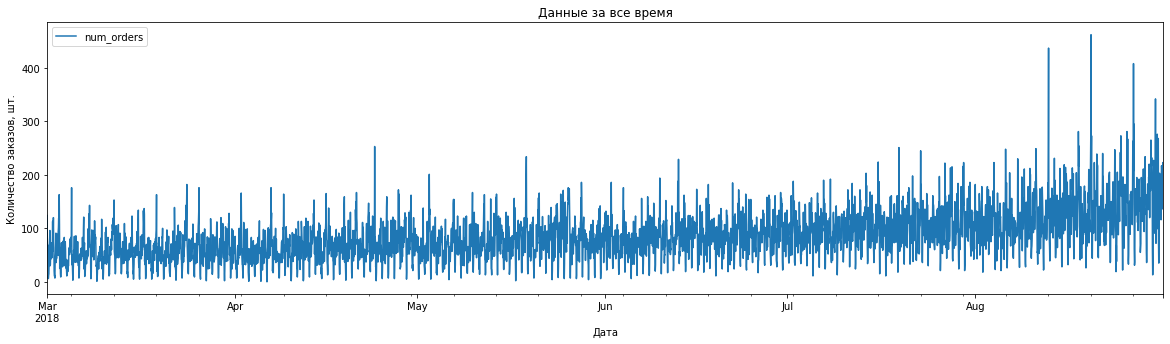

In [5]:
#Отсортируем индекс таблицы.
data.sort_index(inplace=True)

#Выполним ресемплирование
data = data.resample('1H').sum()

#Построим график
data.plot(figsize=(20,5))
plt.title('Данные за все время')
plt.xlabel('Дата')
plt.ylabel('Количество заказов, шт.')
plt.show()

### Вывод
Данные проверили, все впорядке.

## Анализ

In [6]:
#Посмотрим минимум и максимум
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

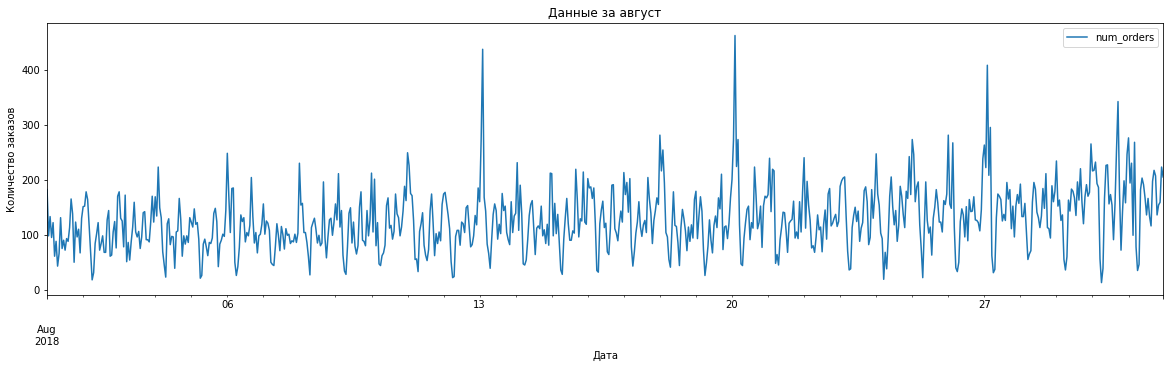

In [7]:
#Посмотрим данные за последний месяц, так как там идет рост
data_08 = data['2018-08']
data_08.plot(figsize=(20,5))
plt.title('Данные за август')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

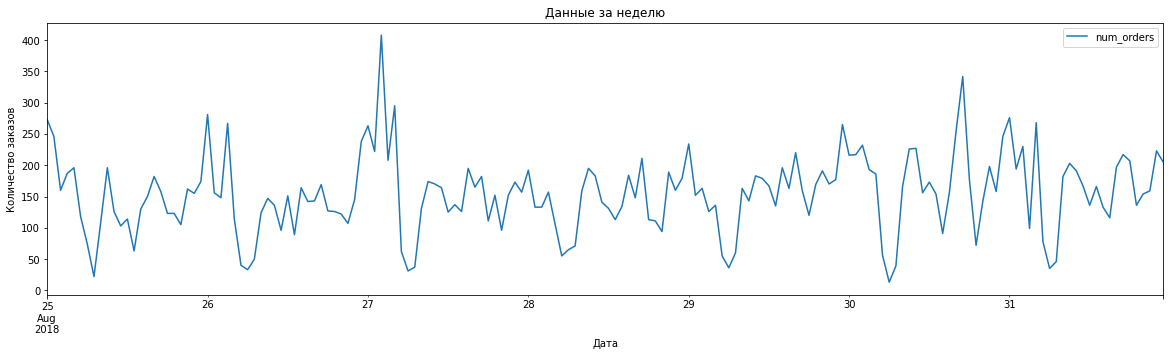

In [8]:
#Посмотрим данные за неделю
data_08_week = data['2018-08-25':]
data_08_week.plot(figsize=(20,5))
plt.title('Данные за неделю')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

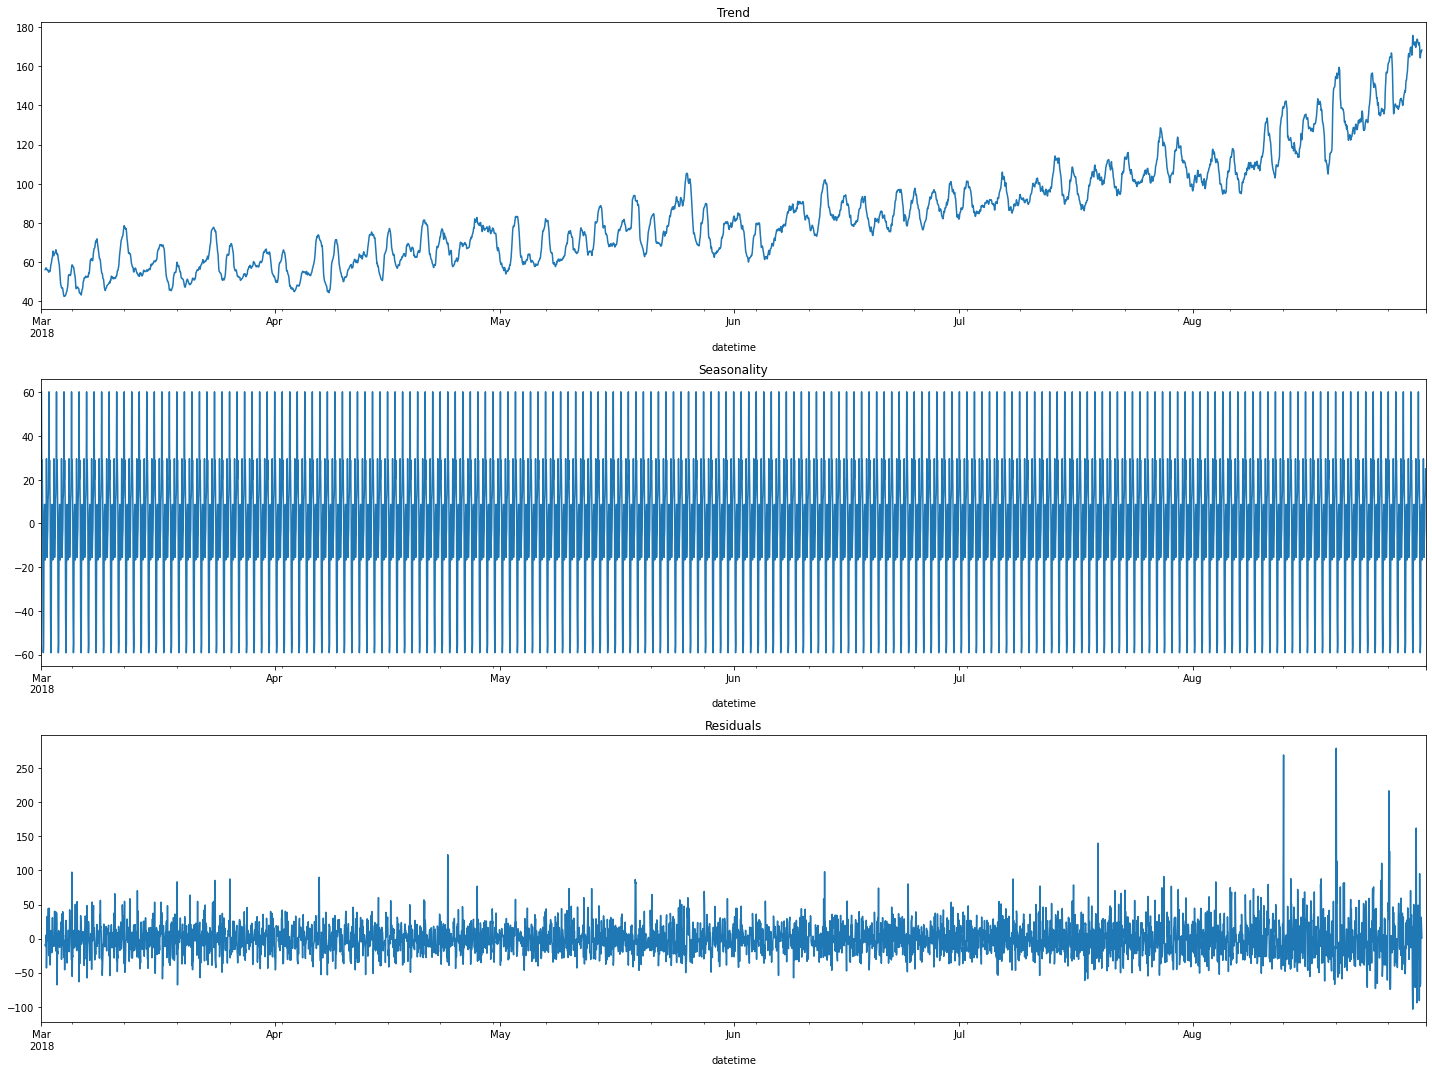

In [9]:
#Посмотрим на тренд и сезонность за все время
decomposed = seasonal_decompose(data)

plt.figure(figsize=(20, 15))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

По тренду видим общее увеличение количества заказов

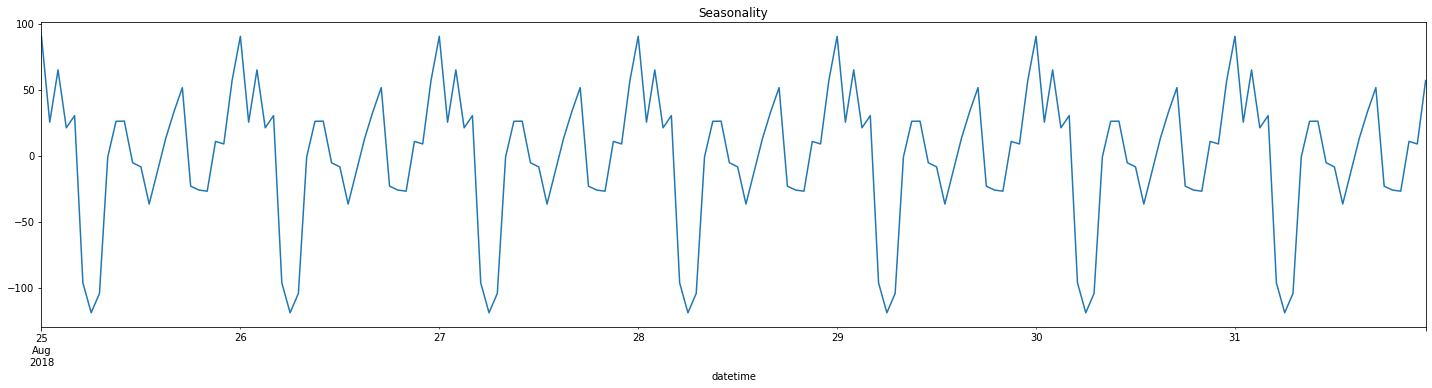

In [10]:
#Посмотрим на сезонность за неделю
decomposed_08_week = seasonal_decompose(data_08_week)

plt.figure(figsize=(20, 15))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed_08_week.seasonal.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Seasonality')
plt.tight_layout()

По сезонности мы видим, что заказы резко падают ночью, и так же резко растут утром.

### Вывод
1. По тренду видим общее увеличение количества заказов
2. По сезонности мы видим, что заказы резко падают ночью, и так же резко растут утром.

## Обучение

Напишем функцию make_features(), чтобы прибавить к таблице новые признаки

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    #Добавим календарные признаки год, месяц, день и день недели
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    #Сдвиги
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    #Скользящее среднее
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
make_features(data, 50, 24)

data.dropna(inplace=True)

data.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,3,5,2,108.0,163.0,72.0,119.0,101.0,93.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,65.291667
2018-03-03 03:00:00,64,3,5,3,25.0,108.0,163.0,72.0,119.0,101.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,63.208333
2018-03-03 04:00:00,44,3,5,4,64.0,25.0,108.0,163.0,72.0,119.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,63.208333
2018-03-03 05:00:00,15,3,5,5,44.0,64.0,25.0,108.0,163.0,72.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,64.208333
2018-03-03 06:00:00,9,3,5,6,15.0,44.0,64.0,25.0,108.0,163.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,64.375000


In [12]:
#Разобьем на обучающую и тестовую выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### LinearRegression

In [13]:
%%time

#Обучим модель
model_lr = LinearRegression()

model_lr.fit(features_train, target_train)
 
train_pred = model_lr.predict(features_train)
 
print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred)**0.5)

RMSE обучающей выборки: 23.43211593447595
CPU times: user 46.5 ms, sys: 73.4 ms, total: 120 ms
Wall time: 74.6 ms


### RandomForestRegressor

In [14]:
%%time

#Обучим модель
model_rfl = RandomForestRegressor(random_state=RANDOM_STATE)

model_rfl.fit(features_train, target_train)
 
train_pred = model_rfl.predict(features_train)
 
print("RMSE обучающей выборки:", mean_squared_error(target_train, train_pred)**0.5)

RMSE обучающей выборки: 8.473546113423806
CPU times: user 9.97 s, sys: 38 ms, total: 10 s
Wall time: 10.1 s


### CatBoostRegressor

In [15]:
%%time

model_cbr = CatBoostRegressor()
params_grid_cat = {
    'n_estimators' : [50, 100],
    'verbose' : [0],
    'random_state' : [RANDOM_STATE],
    'max_depth' : [5, 7, 10]
}

tscv = TimeSeriesSplit(n_splits=5)
grid_cv = GridSearchCV(estimator=model_cbr, param_grid=params_grid_cat, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(features_train, target_train)
print('Лучшие параметры: ', grid_cv.best_params_)
print('RMSE значение на тренеровочной выборке: {:.2f}'.format((-grid_cv.best_score_) ** 0.5))

Лучшие параметры:  {'max_depth': 5, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
RMSE значение на тренеровочной выборке: 24.47
CPU times: user 1min 16s, sys: 559 ms, total: 1min 16s
Wall time: 1min 37s


## Тестирование

Протестируем модель RandomForestRegressor с лучшими показателями RMSE на обучающей выборки: 8.473546113423806

### RandomForestRegressor

In [16]:
%%time

#Обучим модель
#model_rfl = RandomForestRegressor()

#model_rfl.fit(features_train, target_train)
 
target_pred = model_rfl.predict(features_test)
 
print("RMSE тестовой выборки: ", mean_squared_error(target_test, target_pred)**0.5)

RMSE тестовой выборки:  43.28530753101934
CPU times: user 19.8 ms, sys: 4 ms, total: 23.8 ms
Wall time: 26.7 ms


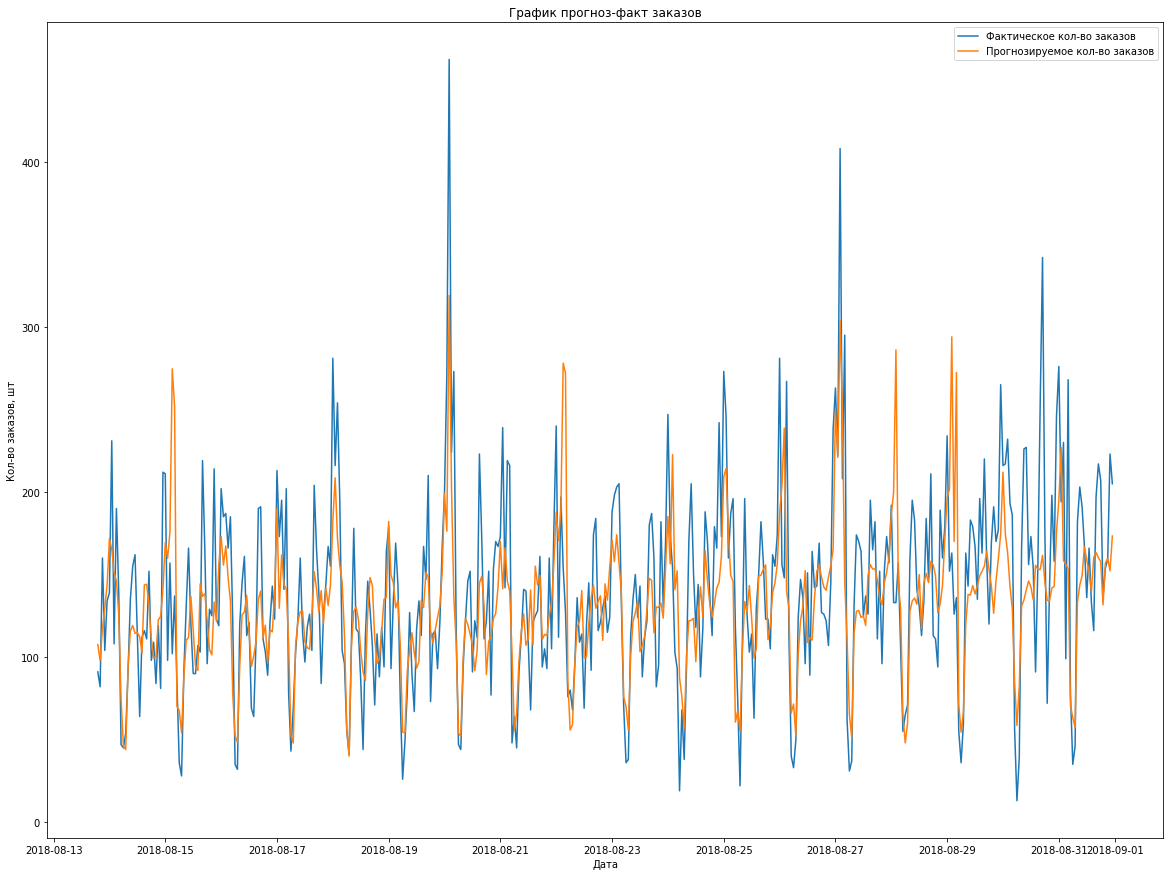

In [17]:
plt.figure(figsize=(20, 15))
plt.plot(target_test.index, target_test, label='Фактическое кол-во заказов')
plt.plot(target_test.index, target_pred, label='Прогнозируемое кол-во заказов')
plt.title('График прогноз-факт заказов')
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов, шт')
plt.legend()
plt.show()

### Вывод
Лучше всего показала себя модель RandomForestRegressor. 
1. RMSE значение на тренеровочной выборке: 8.47
2. RMSE значение на тестовой выборке:  43.28 < 48

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48